# Using AWS SageMaker to Invoke Holo1 for a localization task

Holo1 is an Action Vision-Language Model (VLM) developed by [H Company](https://www.hcompany.ai/) for use in the Surfer-H web agent system. It is designed to interact with web interfaces like a human user. 

As part of a broader agentic architecture, Holo1 acts as a policy, localizer, or validator, helping the agent understand and act in digital environments.

This notebook demonstrates how to call Holo1 (3B or 7B) hosted on Amazon SageMaker using the `invoke_endpoint` API provided by the SageMaker Runtime client.


## Prerequisites

Before running this notebook, ensure you have:

- Holo1 deployed on SageMaker through the AWS marketplace (with a known endpoint name) (see the [deploy recipe](https://github.com/hcompai/hai-cookbook/blob/main/holo1/sagemaker/deploy.ipynb))
- AWS credentials with permissions to invoke the endpoint

## Contents

1. [Install required python dependencies](#1-install-required-python-dependencies)
2. [Set Up the SageMaker Runtime Client](#2-set-up-the-sagemaker-runtime-client)
3. [Prepare the Input Payload](#3-prepare-the-input-payload)
4. [Invoke SageMaker endpoint](#4-invoke-sagemaker-endpoint)
5. [Invoke SageMaker endpoint with structured output](#5-invoke-sagemaker-endpoint-with-structured-output)



## 1. Install required python dependencies

In [ ]:
%pip install -qU sagemaker boto3 rich openai pydantic Pillow

In [2]:
import boto3
import json
import rich
import re

from typing import Any, Literal
from PIL import Image
import pathlib as pl
import sys
from IPython.display import display

In [3]:
# Add directory to the Python path to import utils package
project_root_dir = pl.Path.cwd().resolve().parents[1]
sys.path.append(str(project_root_dir))

In [4]:
# Get cursor .png path
cursor_img_path = project_root_dir / "data" / "cursor_image_red.png"

## 2. Set Up the SageMaker Runtime Client

In [5]:
# Specify the profile name to use for invoking the model
AWS_PROFILE: str | None = None
# Holo1 model name: "holo1-3b" or "holo1-7b"
MODEL_NAME: Literal["holo1-3b", "holo1-7b"] = "holo1-3b"
# Specify the endpoint name of the Holo1 model deployed on SageMaker
ENDPOINT_NAME: str = "<endpoint-name>"

session = boto3.Session(profile_name=AWS_PROFILE)
sagemaker_client = session.client("sagemaker-runtime")

## 3. Prepare the Input Payload

Holo1 models are served using vLLM, with the endpoint exposing the v1/chat/completions API.

In this example, Holo1 is prompted to identify the correct location to click in order to successfully select a date on the calendar.

**Important**: The input image must be resized using Qwen’s `smart_resize` method. This is crucial because vLLM performs its own internal resizing, which can alter the original image dimensions and lead to inaccurate or misaligned coordinate predictions from the model.

In [11]:
# Prepare inference request
from utils.image import smart_resize

# Load image
image_path = project_root_dir / "data" / "calendar_example.jpg"
image = Image.open(image_path)

# Resize the image so that predicted absolute coordinates match the size of the image.
resized_height, resized_width = smart_resize(height=image.height, width=image.width)
image = image.resize(size=(resized_width, resized_height), resample=None)

task = "Select July 14th as the check-out date"

## 4. Invoke Sagemaker endpoint 

Click(350, 342)

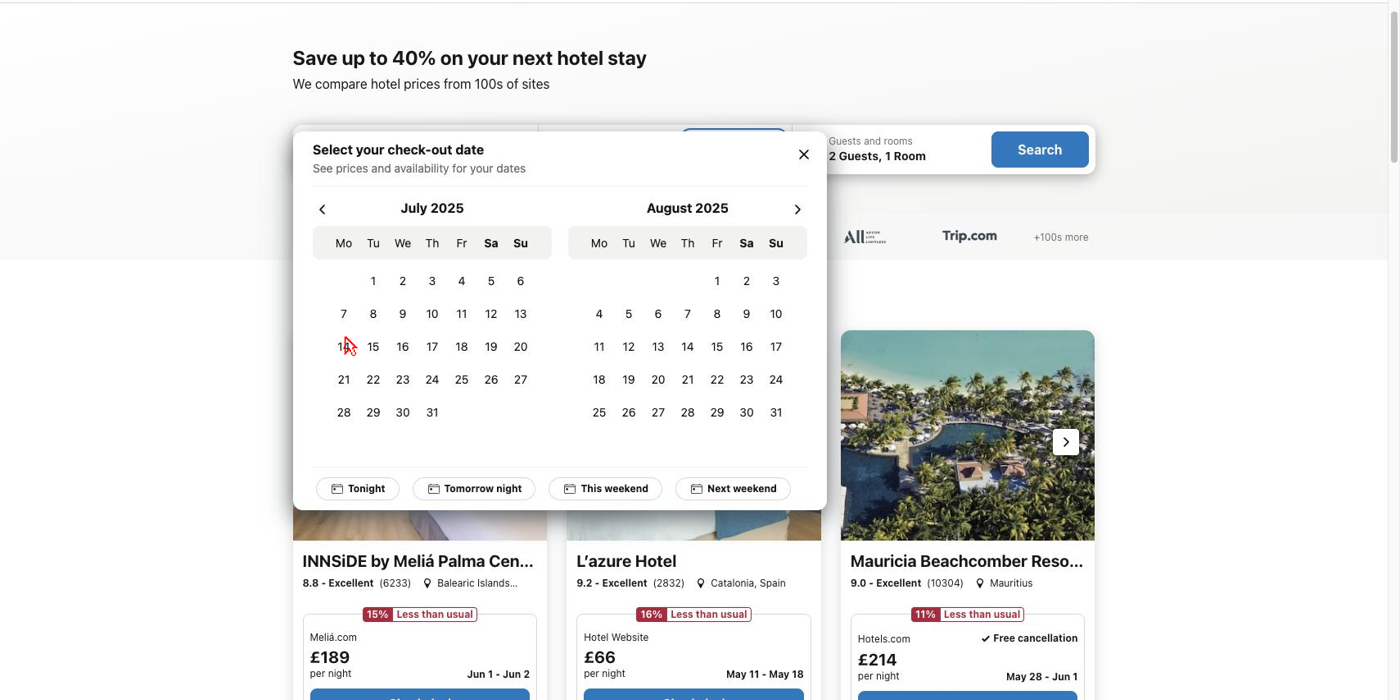

In [12]:
from openai.types.chat.chat_completion import ChatCompletion
from utils.image import draw_image_with_click
from utils.localization import build_localization_task_messages

chat_completion_request = {
    "model": MODEL_NAME,
    "messages": build_localization_task_messages(
        task=task,
        image=image,
        image_format="JPEG",
    ),
    "temperature": 0,
}

response = sagemaker_client.invoke_endpoint(
    EndpointName=ENDPOINT_NAME,
    ContentType="application/json",
    Accept="application/json",
    Body=json.dumps(chat_completion_request),
)

chat_completion = ChatCompletion(**json.loads(response.get("Body").read().decode()))
rich.print(chat_completion.choices[0].message.content)


def extract_click(response: str) -> tuple[int, int]:
    """Extract the click position from the LLM response."""
    pattern = r"Click\(\s*(\d+)\s*,\s*(\d+)\s*\)"
    match = re.search(pattern, response)
    if match:
        x, y = map(int, match.groups())
        return x, y
    raise ValueError("No click position found in the response")


# Parse the output
click_str = chat_completion.choices[0].message.content
x, y = extract_click(click_str)

display(draw_image_with_click(image, x, y, cursor_img_path))

## 5. Invoke Sagemaker endpoint with structured output

Holo1 served by vLLM supports structured output. In the following request, the output json schema will be provided as input of the request.

ClickAction(action='click', x=350, y=348)

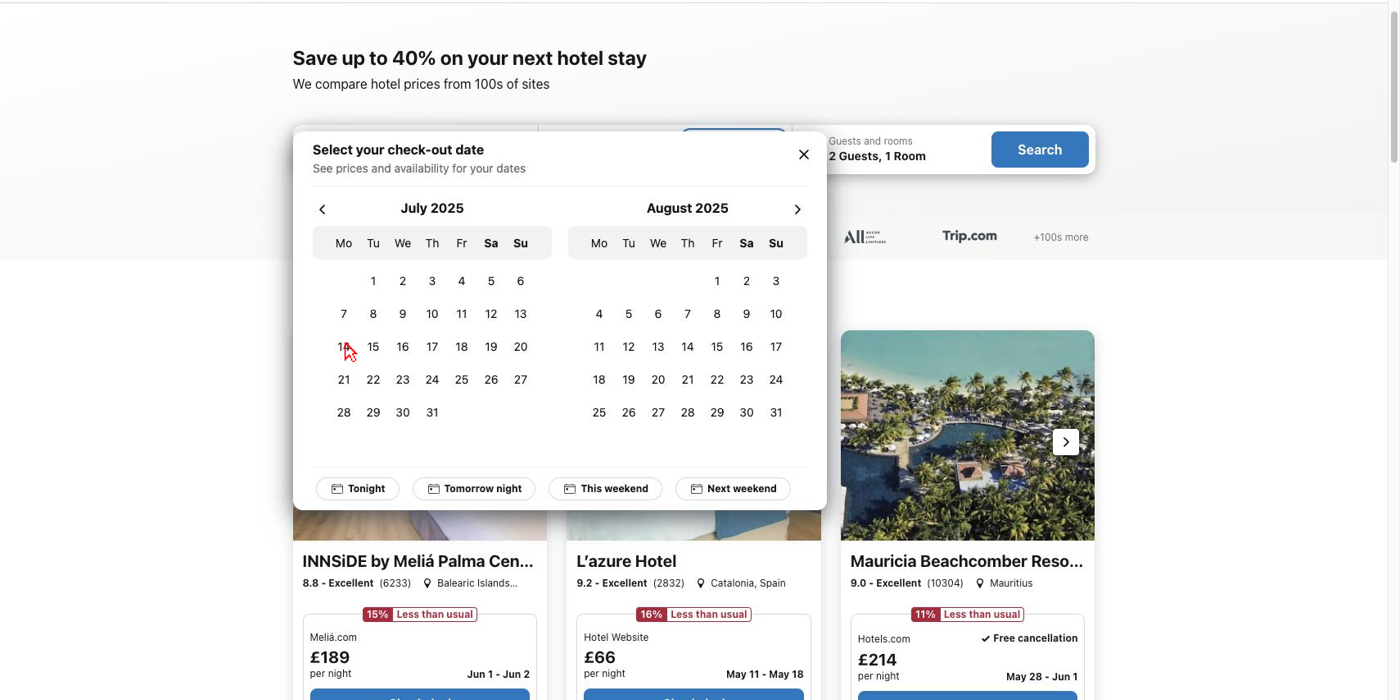

In [13]:
from openai.types.chat.chat_completion import ChatCompletion
from utils.image import draw_image_with_click
from utils.localization import ClickAction, build_localization_task_messages_structured_output

chat_completion_request = {
    "model": MODEL_NAME,
    "messages": build_localization_task_messages_structured_output(
        task=task,
        image=image,
        image_format="JPEG",
    ),
    "temperature": 0,
    "guided_json": ClickAction.model_json_schema(),
}

response = sagemaker_client.invoke_endpoint(
    EndpointName=ENDPOINT_NAME,
    ContentType="application/json",
    Accept="application/json",
    Body=json.dumps(chat_completion_request),
)

chat_completion = ChatCompletion(**json.loads(response.get("Body").read().decode()))
click = ClickAction(**json.loads(chat_completion.choices[0].message.content))
rich.print(click)

display(draw_image_with_click(image, click.x, click.y, cursor_img_path))